In [ ]:
pip install wfdb

     |████████████████████████████████| 133kB 9.6MB/s 


In [ ]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=50c6573fead34ebc86967f57394007935e442a9e9b2a53ccbbb6aaf4cdaa5443
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import pandas as pd
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import wget
import zipfile

database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

if not database_path.exists():
    url = f'https://storage.googleapis.com/mitdb-1.0.0.physionet.org/{database_filename}'
    wget.download(url)
    with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

In [ ]:
records = np.loadtxt("gdrive/MyDrive/mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

In [ ]:

invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]

In [ ]:
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0

In [ ]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

In [ ]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
for subject in records:
    record = wfdb.rdrecord(f'gdrive/MyDrive/mit-bih-arrhythmia-database-1.0.0/{subject}')
    annotation = wfdb.rdann(f'gdrive/MyDrive/mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

In [ ]:
subject_map = pd.DataFrame(subject_map)
subject_map.head(10)
len(subject_map)

48

In [ ]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

In [ ]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)

In [ ]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [ ]:

X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [ ]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

In [ ]:
X_val.shape,y_val.shape

((26259, 2160, 1), (26259, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential([
    Conv1D(
        filters=8,
        kernel_size=4,
        strides=1,
        input_shape=(sequence_size, n_features),
        padding="same",
        activation="relu"
    ),
    Flatten(),
    Dropout(0.5),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2160, 8)           40        
_________________________________________________________________
flatten (Flatten)            (None, 17280)             0         
_________________________________________________________________
dropout (Dropout)            (None, 17280)             0         
_________________________________________________________________
output (Dense)               (None, 1)                 17281     
Total params: 17,321
Trainable params: 17,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=15,
    validation_data=(X_val, y_val)
)

Epoch 1/15


ValueError: ignored

In [ ]:
cnn_model.evaluate(X_val, y_val)

821/821 [==============================] - 2s 2ms/step - loss: 0.7004 - accuracy: 0.8164


[0.7003925442695618, 0.8163677453994751]

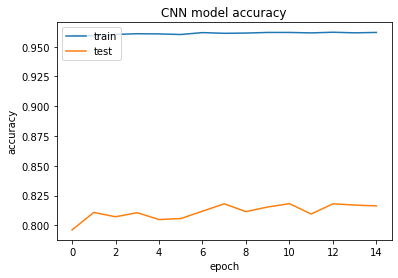

In [ ]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

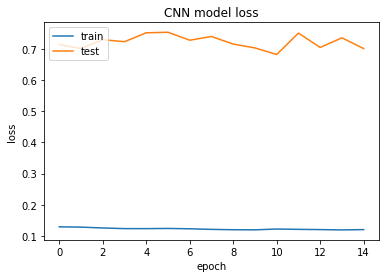

In [ ]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
sequence_size = X_train.shape[1]
n_features = 1 
n_subsequences = 4
subsequence_size = int(sequence_size / n_subsequences)

# Reshaping to be (samples, subsequences, sequence, feature)
X_train = X_train.reshape(-1, n_subsequences, subsequence_size, n_features)
X_val = X_val.reshape(-1, n_subsequences, subsequence_size, n_features)

In [ ]:
cnn_lstm_model = Sequential([
    TimeDistributed(
        Conv1D(
            filters=8,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu"
        ), 
        input_shape=(n_subsequences, subsequence_size, n_features)
    ),
    TimeDistributed(Flatten()),
    LSTM(units=4),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_lstm_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 4, 540, 8)         40        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 4320)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 69200     
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 69,245
Trainable params: 69,245
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_params = {
    "batch_size": 128,
    "epochs": 15,
    "verbose": 1,
    "validation_data": (X_val, y_val),
}

history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, **train_params)

Epoch 1/15
648/648 [==============================] - 4s 6ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 1.1095 - val_accuracy: 0.7820
Epoch 2/15
648/648 [==============================] - 4s 6ms/step - loss: 0.0178 - accuracy: 0.9947 - val_loss: 1.0371 - val_accuracy: 0.7835
Epoch 3/15
648/648 [==============================] - 4s 5ms/step - loss: 0.0167 - accuracy: 0.9950 - val_loss: 1.2084 - val_accuracy: 0.7762
Epoch 4/15
643/648 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9953

KeyboardInterrupt: ignored

In [ ]:
cnn_lstm_model.evaluate(X_val, y_val)

821/821 [==============================] - 2s 3ms/step - loss: 1.0273 - accuracy: 0.7882


[1.027268648147583, 0.788224995136261]

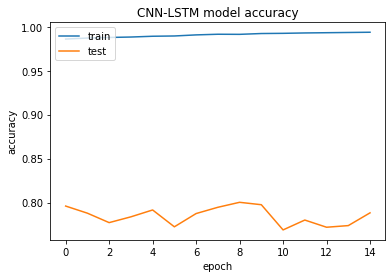

In [ ]:
# summarize history for accuracy
plt.plot(history_cnn_lstm.history['accuracy'])
plt.plot(history_cnn_lstm.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

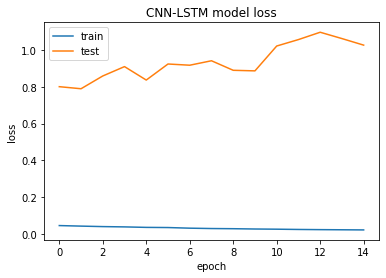

In [ ]:
# summarize history for loss
plt.plot(history_cnn_lstm.history['loss'])
plt.plot(history_cnn_lstm.history['val_loss'])
plt.title('CNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()